This notebook is similar to the run-to-run stuff, however will only include the steps necessary for filtering the tables and running beta diversity. The actual analysis of this output should be included in the run-to-run notebook

In [13]:
%matplotlib inline
import pandas as pd
from skbio import DistanceMatrix
from os.path import join
from skbio.stats.ordination import pcoa


Load the mapping file and filter it to 16S
------------

In [2]:
home = '/home/office-microbe-files'
map_fp = join(home, 'master_map_150908.txt')

In [3]:
sample_md = pd.read_csv(map_fp, sep='\t', index_col=0, dtype=str)
sample_md = sample_md[sample_md['16SITS'] == '16S']

create directory structure
-------------------
```bash
mkdir run-12
mkdir run-12/blanks
mkdir run-12/blanks/10 run-12/blanks/100 run-12/blanks/1000
cp -r run-12/blanks/ run-12/sl
cp -r run-12/ run-13
```

Filter OTU table to be 1-2 and 1-3 samples only
-------------------
The first thing to do is to filter the OTU tables down into two different OTU tables, one that contains just run 1 and 2 samples, and another that only contains run 1 and 3. This is a bit weird, but these are the only combinations that have techincal replicates, and they don't overlap...

In [4]:
run_1_2_ids = sample_md[(sample_md["Run"] == "1") | (sample_md["Run"] == "2")].index
run_1_2_fp = open("run-12/samples_to_filter.txt", "w")
run_1_2_fp.write('\n'.join(run_1_2_ids))
run_1_2_fp.close()

In [5]:
len(run_1_2_ids)

1611

In [37]:
run_1_3_ids = sample_md[(sample_md["Run"] == "1") | (sample_md["Run"] == "3")].index
run_1_3_fp = open("run-13/samples_to_filter.txt", "w")
run_1_3_fp.write('\n'.join(run_1_3_ids))
run_1_3_fp.close()

###QIIME commands for filtering OTU tables  

```bash
filter_samples_from_otu_table.py -i /home/office-microbe-files/pick_otus_out_97/otu_table_mc2_w_tax_no_pynast_failures.biom -o run-12/otu-table.biom --sample_id_fp run-12/samples_to_filter.txt

filter_samples_from_otu_table.py -i /home/office-microbe-files/pick_otus_out_97/otu_table_mc2_w_tax_no_pynast_failures.biom -o run-13/otu-table.biom --sample_id_fp run-13/samples_to_filter.txt
```


Find the most abundant taxa in the blank samples
-----------------------------

This should probably not be done on the rarefied tables as we are assuming that this is contamination.

##1. First we should find the most abundant OTUs in each run

In [8]:
table_fp = join(home, 'pick_otus_out_97/otu_table_mc2_w_tax_no_pynast_failures.txt')
table = pd.read_csv(table_fp, sep='\t', skiprows=1, index_col=0, dtype="object")
table.index = table.index.astype(str)

In [9]:
def get_ids(sample_metadata, otu_table, run, n_otus):
    run_ids = sample_metadata[(sample_metadata['Run'] == run) & (sample_metadata['OfficeSample'] == 'no')].index
    run_otus = otu_table[list(set(run_ids) & set(otu_table.columns))].sum(axis=1)
    run_otus = run_otus.sort(ascending=False, inplace=False)[:n_otus].index.tolist()
    return run_otus

While some of the OTU IDs might overlap here, we are still taking the top n for each run

In [10]:
#This is slow and stupid but it works.

runs = ['12', '13']
n_otus = [10, 100, 1000]
for n_otu in n_otus:
    for run in runs:
        print(run)
        run_1_otus = get_ids(sample_md, table, "1", n_otu)
        run_2_otus = get_ids(sample_md, table, "2", n_otu)
        run_3_otus = get_ids(sample_md, table, "3", n_otu)
        otu_fp = 'run-{0}/blanks/{1}/otus-to-filter.txt'.format(run, n_otu)
        print(otu_fp)
        if run == '12':
            otus = '\n'.join(run_1_otus + run_2_otus)
        else:
            otus = '\n'.join(run_1_otus + run_3_otus)
        otus_fp = open('run-{0}/blanks/{1}/otus-to-filter.txt'.format(run, n_otu), 'w')
        otus_fp.write(otus)
        otus_fp.close()
    

12
run-12/blanks/10/otus-to-filter.txt
13
run-13/blanks/10/otus-to-filter.txt
12
run-12/blanks/100/otus-to-filter.txt
13
run-13/blanks/100/otus-to-filter.txt
12
run-12/blanks/1000/otus-to-filter.txt
13
run-13/blanks/1000/otus-to-filter.txt


2. Filter those samples from the OTU tables
------------------------------

```bash
filter_otus_from_otu_table.py -i run-12/otu-table.biom -e run-12/blanks/10/otus-to-filter.txt -o run-12/blanks/10/blank_filtered_table.biom

filter_otus_from_otu_table.py -i run-13/otu-table.biom -e run-13/blanks/10/otus-to-filter.txt -o run-13/blanks/10/blank_filtered_table.biom

filter_otus_from_otu_table.py -i run-12/otu-table.biom -e run-12/blanks/100/otus-to-filter.txt -o run-12/blanks/100/blank_filtered_table.biom

filter_otus_from_otu_table.py -i run-13/otu-table.biom -e run-13/blanks/100/otus-to-filter.txt -o run-13/blanks/100/blank_filtered_table.biom

filter_otus_from_otu_table.py -i run-12/otu-table.biom -e run-12/blanks/1000/otus-to-filter.txt -o run-12/blanks/1000/blank_filtered_table.biom

filter_otus_from_otu_table.py -i run-13/otu-table.biom -e run-13/blanks/1000/otus-to-filter.txt -o run-13/blanks/1000/blank_filtered_table.biom
```

3. Rarefy tables
--------------

```bash
single_rarefaction.py -i run-12/otu-table.biom-o run-12/rarefied_table.biom -d 1000

single_rarefaction.py -i run-13/otu-table.biom-o run-13/rarefied_table.biom -d 1000

single_rarefaction.py -i run-12/blanks/10/blank_filtered_table.biom -o run-12/blanks/10/rarefied_blank_filtered_table.biom -d 1000

single_rarefaction.py -i run-13/blanks/10/blank_filtered_table.biom -o run-13/blanks/10/rarefied_blank_filtered_table.biom -d 1000

single_rarefaction.py -i run-12/blanks/100/blank_filtered_table.biom -o run-12/blanks/100/rarefied_blank_filtered_table.biom -d 1000

single_rarefaction.py -i run-13/blanks/100/blank_filtered_table.biom -o run-13/blanks/100/rarefied_blank_filtered_table.biom -d 1000

single_rarefaction.py -i run-12/blanks/1000/blank_filtered_table.biom -o run-12/blanks/1000/rarefied_blank_filtered_table.biom -d 1000

single_rarefaction.py -i run-13/blanks/1000/blank_filtered_table.biom -o run-13/blanks/1000/rarefied_blank_filtered_table.biom -d 1000
```

4. Run beta diversity on those files
--------------------

```bash
parallel_beta_diversity.py -i run-12/rarefied_table.biom -o run-12/bd_out -O 30 -t /home/office-microbe-files/pick_otus_out_97/rep_set.tre

parallel_beta_diversity.py -i run-13/rarefied_table.biom -o run-13/bd_out -O 30 -t /home/office-microbe-files/pick_otus_out_97/rep_set.tre

parallel_beta_diversity.py -i run-12/blanks/10/rarefied_blank_filtered_table.biom -o run-12/blanks/10/bd_out -O 30 -t /home/office-microbe-files/pick_otus_out_97/rep_set.tre

parallel_beta_diversity.py -i run-13/blanks/10/rarefied_blank_filtered_table.biom -o run-13/blanks/10/bd_out -O 30 -t /home/office-microbe-files/pick_otus_out_97/rep_set.tre

parallel_beta_diversity.py -i run-12/blanks/100/rarefied_blank_filtered_table.biom -o run-12/blanks/100/bd_out -O 30 -t /home/office-microbe-files/pick_otus_out_97/rep_set.tre

parallel_beta_diversity.py -i run-13/blanks/100/rarefied_blank_filtered_table.biom -o run-13/blanks/100/bd_out -O 30 -t /home/office-microbe-files/pick_otus_out_97/rep_set.tre

parallel_beta_diversity.py -i run-12/blanks/1000/rarefied_blank_filtered_table.biom -o run-12/blanks/1000/bd_out -O 30 -t /home/office-microbe-files/pick_otus_out_97/rep_set.tre

parallel_beta_diversity.py -i run-13/blanks/1000/rarefied_blank_filtered_table.biom -o run-13/blanks/1000/bd_out -O 30 -t /home/office-microbe-files/pick_otus_out_97/rep_set.tre
```

/home/johnchase/.conda/envs/q2d2/lib/python3.4/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:102: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.8176776777105758 and the largest is 68.77862876813927.
  RuntimeWarning


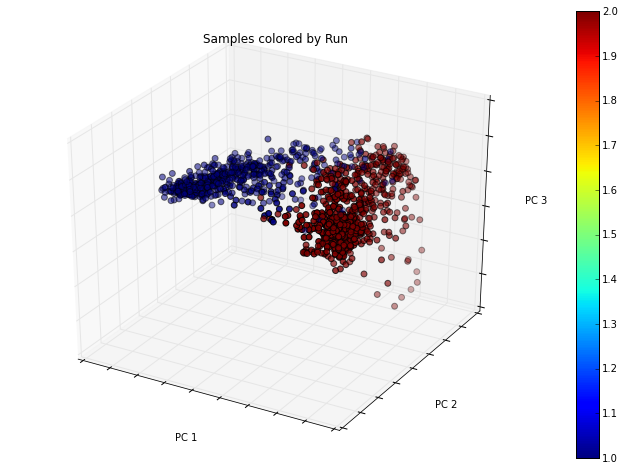

In [57]:
weighted_dm_fp = 'run122/blanks/10/bd_out/weighted_unifrac_rarefied_blank_filtered_table.txt'
weighted_dm = DistanceMatrix.read(weighted_dm_fp)
weighted_pcoa = pcoa(weighted_dm)
fig = weighted_pcoa.plot(df=sample_md,
                        column='Run',
                        axis_labels=['PC 1', 'PC 2', 'PC 3'],
                        title='Samples colored by Run',
                        s=35).set_size_inches(12, 8)


/home/johnchase/.conda/envs/q2d2/lib/python3.4/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:102: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.7309679650564497 and the largest is 57.601946044170504.
  RuntimeWarning


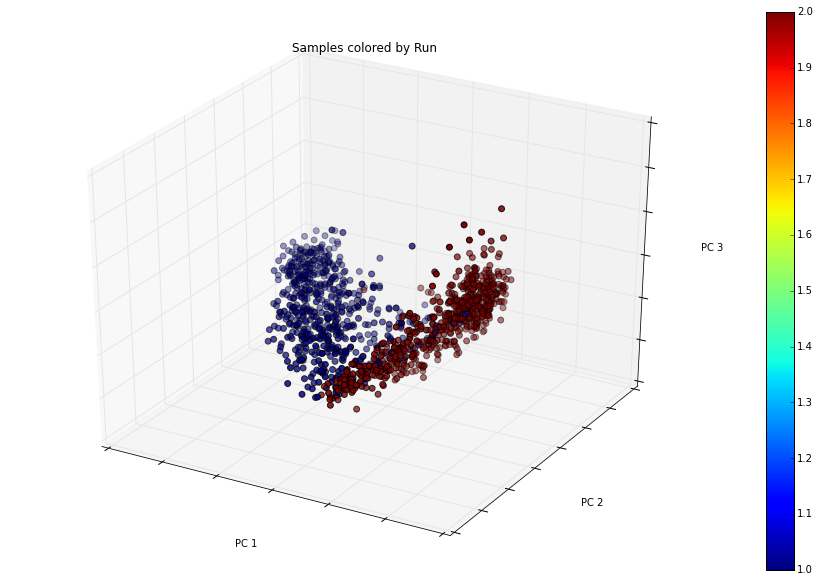

In [58]:
weighted_dm_fp = 'run122/blanks/100/bd_out/weighted_unifrac_rarefied_blank_filtered_table.txt'
weighted_dm = DistanceMatrix.read(weighted_dm_fp)
weighted_pcoa = pcoa(weighted_dm)
fig = weighted_pcoa.plot(df=sample_md,
                        column='Run',
                        axis_labels=['PC 1', 'PC 2', 'PC 3'],
                        title='Samples colored by Run',
                        s=35).set_size_inches(16, 10)


/home/johnchase/.conda/envs/q2d2/lib/python3.4/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:102: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.601291612076563 and the largest is 57.059491220607825.
  RuntimeWarning


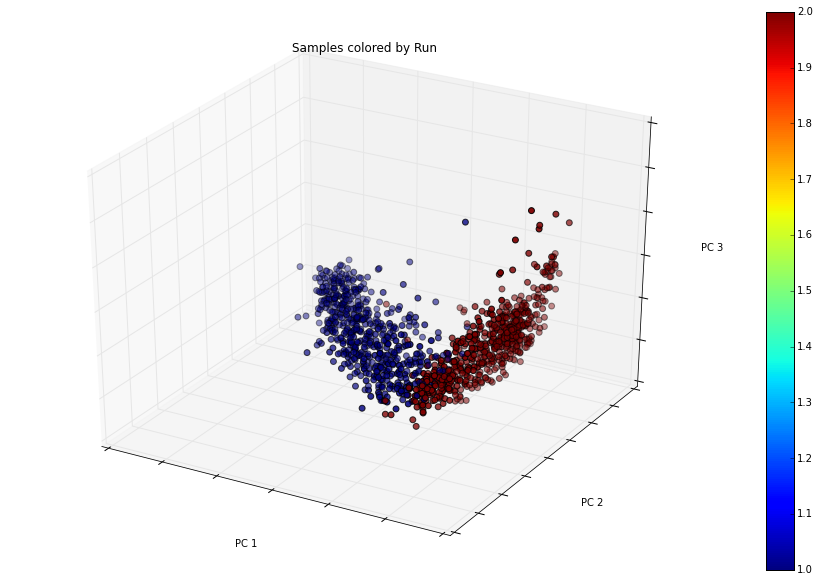

In [59]:
weighted_dm_fp = 'run122/blanks/1000/bd_out/weighted_unifrac_rarefied_blank_filtered_table.txt'
weighted_dm = DistanceMatrix.read(weighted_dm_fp)
weighted_pcoa = pcoa(weighted_dm)
fig = weighted_pcoa.plot(df=sample_md,
                        column='Run',
                        axis_labels=['PC 1', 'PC 2', 'PC 3'],
                        title='Samples colored by Run',
                        s=35).set_size_inches(16, 10)

In [48]:
weighted_dm.shape

(1193, 1193)

In [56]:
from skbio.stats.distance import anosim
anosim(weighted_dm, sample_md, column='Run', permutations=999)

method name                  ANOSIM
test statistic name               R
sample size                    1193
number of groups                  2
test statistic            0.6354696
p-value                       0.001
number of permutations          999
Name: ANOSIM results, dtype: object

In [43]:
taxa_map_fp = join(home, 'pick_otus_out_97/uclust_assigned_taxonomy/rep_set_tax_assignments.txt')
taxa_df = pd.read_csv(taxa_map_fp, sep='\t', names=['TaxID', 'taxonomy'], index_col=0, usecols=[0, 1], dtype=object)

In [44]:

taxa_df['taxonomy']['570350']

'k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingobium; s__'